<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/entrenamiento_bayesiano_eje_y_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importo las librerias
import h5py
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
tfd = tfp.distributions
tfpl = tfp.layers
from sklearn.model_selection import train_test_split

In [2]:
## hago el mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Proceso de carga de los datos

### Data de la universidad coreana

In [3]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_y"
with h5py.File(path_features, 'r') as hf:
    x_features = hf['features_y'][:]

In [4]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/y_targets"
with h5py.File(path_features, 'r') as hf:
    y_targets = hf['y_targets'][:]

### Data from case west reserve university DRIVE END

In [5]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_1/features"
with h5py.File(path_features, 'r') as hf:
    x_features_1 = hf['features'][:]


In [6]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_1/targets"
with h5py.File(path_features, 'r') as hf:
    y_targets_1 = hf['targets'][:]

### Data from case west reserve university FAN END

In [7]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_2/features"
with h5py.File(path_features, 'r') as hf:
    x_features_2= hf['features'][:]


In [8]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_2/targets"
with h5py.File(path_features, 'r') as hf:
    y_targets_2 = hf['targets'][:]

### Creacion de la BNN

In [9]:
## def prior weight distribution N(1,0) and not trainable
# Define the prior weight distribution N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [10]:
# Define the posterior weight distribution Multivariate Gaussian distribution
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

## data entrenada con los solo dos data set peri aumentando el tamaño de los train test

In [11]:
###3 concateno todo
y_targets = y_targets.reshape(len(y_targets), 1)
x_features_4=np.concatenate((x_features ,x_features_2))
y_targets_4=np.concatenate((y_targets ,y_targets_2))





In [42]:
del model

In [43]:
x_train,y_train=x_features_4,y_targets_4
x_test,y_test=x_features_1,y_targets_1

In [33]:
# x_train,y_train=x_features_1,y_targets_1
# x_test,y_test=x_features_4,y_targets_4

In [44]:
# Define the BNN model
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        input_shape=(14,),
        units=30,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        kl_weight=1/x_train.shape[0],  # KL Weight
        # kl_use_exact=True
    ),

       tfpl.DenseVariational(
        units=25,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=20,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=15,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),


      tfpl.DenseVariational(
        units=12,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=8,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=5,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='sigmoid',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
])

In [45]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 100:
        return 0.001  # Initial learning rate for the first 100 epochs
    elif epoch < 200:
        return 0.0001  # Lower learning rate for the next 100 epochs
    else:
        return 0.00001  # Further lower learning rate for subsequent epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with an optimizer (e.g., Adam) and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

# Train the model with the learning rate scheduler callback
history = model.fit(x_train, y_train, epochs=2000, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy, false_negatives, false_positives = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"False Negatives: {false_negatives:.0f}")
print(f"False Positives: {false_positives:.0f}")

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusion)


Epoch 1/2000
5/5 - 7s - loss: 132.2417 - accuracy: 0.4863 - false_negatives_3: 65.0000 - false_positives_3: 10.0000 - 7s/epoch - 1s/step
Epoch 2/2000
5/5 - 0s - loss: 74.3506 - accuracy: 0.4795 - false_negatives_3: 69.0000 - false_positives_3: 7.0000 - 35ms/epoch - 7ms/step
Epoch 3/2000
5/5 - 0s - loss: 37.2557 - accuracy: 0.6712 - false_negatives_3: 32.0000 - false_positives_3: 16.0000 - 35ms/epoch - 7ms/step
Epoch 4/2000
5/5 - 0s - loss: 26.5113 - accuracy: 0.5959 - false_negatives_3: 45.0000 - false_positives_3: 14.0000 - 34ms/epoch - 7ms/step
Epoch 5/2000
5/5 - 0s - loss: 63.8618 - accuracy: 0.2877 - false_negatives_3: 99.0000 - false_positives_3: 5.0000 - 34ms/epoch - 7ms/step
Epoch 6/2000
5/5 - 0s - loss: 20.2985 - accuracy: 0.5685 - false_negatives_3: 47.0000 - false_positives_3: 16.0000 - 34ms/epoch - 7ms/step
Epoch 7/2000
5/5 - 0s - loss: 23.3514 - accuracy: 0.6507 - false_negatives_3: 35.0000 - false_positives_3: 16.0000 - 34ms/epoch - 7ms/step
Epoch 8/2000
5/5 - 0s - loss: 2

In [49]:
y_test


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [46]:
split_index = int(0.8 * len(x_test))
x_subset = x_test[:split_index]  # Select the first 80% of the test data

# Number of samples for uncertainty estimation
n_samples = 100
predictions = []

#almaceno las prediccion en un array en el formato (cantidad de experimentos, predicciones)=(filas,columnas)
for _ in range(n_samples):
    predictions.append(model.predict(x_subset))

num_experiments=predictions[0].shape[0]
num_samples=len(predictions)
new_variable = np.hstack(predictions)
new_variable = new_variable.reshape(num_experiments, num_samples, 1)
num_experiments, num_samples,value = new_variable.shape
# Create a dictionary where keys are experiment names and values are arrays
data_dict = {f'Experiment {i + 1}': new_variable[i] for i in range(num_experiments)}



3/3 [==============================] - 0s 3ms/step


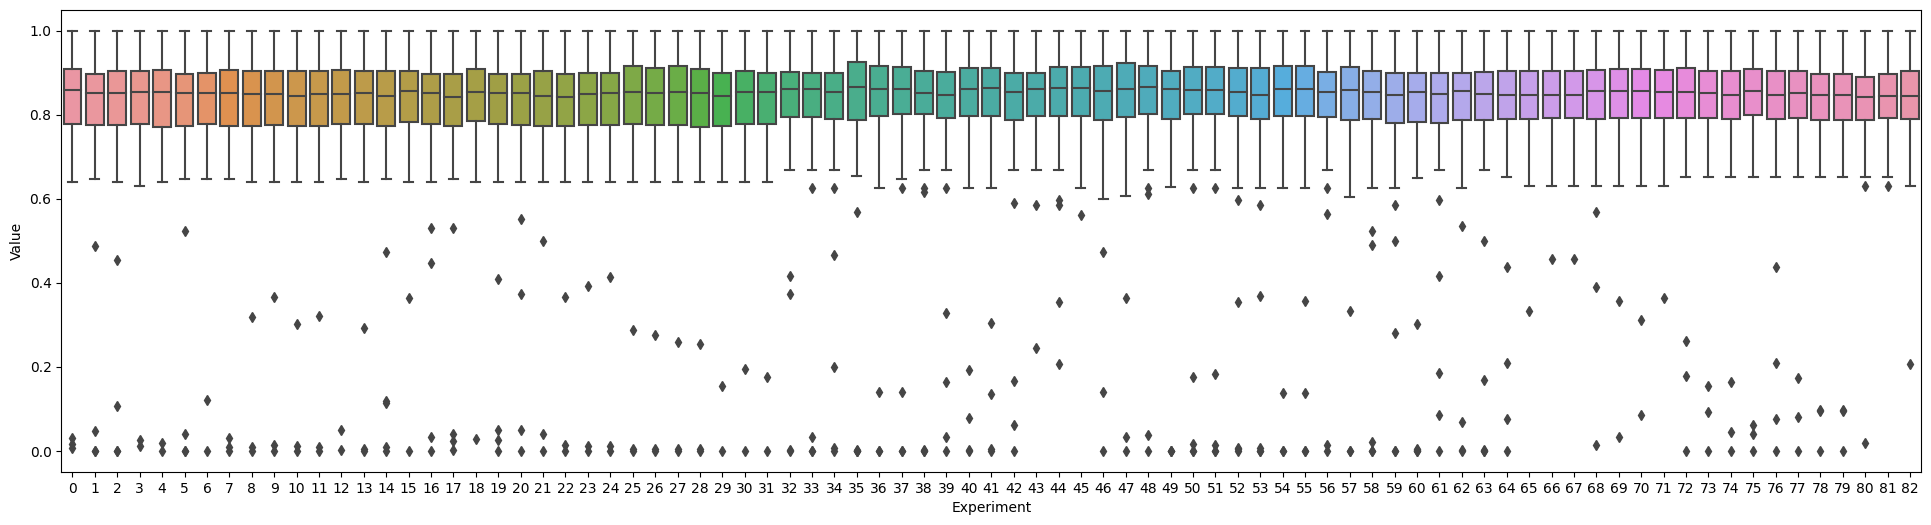

In [47]:
num_rows = len(new_variable)
num_samples = len(new_variable[0])
# Create a box plot using Seaborn
plt.figure(figsize=(24, 6))
sns.boxplot(data=list(data_dict.values()))
plt.xlabel('Experiment')
plt.ylabel('Value')
plt.show()